# Training a Diffusion Model for Animal Face Images

[open in colab](https://colab.research.google.com/github/kungfuai/nano-diffusion/blob/main/notebooks/2_1_nano_diffusion_afhq.ipynb)

## Introduction

This notebook demonstrates how to train a diffusion model on the Animal Faces-HQ (AFHQ) dataset. We'll implement a simplified version of denoising diffusion probabilistic models (DDPM) to generate high-quality animal face images.

### Overview

1. Set up the training configuration
2. Load and preprocess the AFHQ dataset
3. Define the UNet architecture
4. Implement the diffusion process
5. Train the model
6. Generate new images

### Prerequisites
- PyTorch
- datasets library (`pip install datasets==3.0.2`)
- Basic understanding of deep learning and generative models

### Running this notebook in the background

This notebook can take a while to run. If you want to run it in the background, you can use the following command:

```bash
cd notebooks
jupyter execute 2_1_diffusion_afhq.ipynb
```


In [1]:
# !pip install datasets==3.0.2
# !pip install torchvision==0.17.2

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.nn import MSELoss
from torchvision.utils import make_grid
from dataclasses import dataclass
from typing import Dict, Tuple
from torch.utils.data import DataLoader

## Training Configuration

The `TrainingConfig` class below defines all hyperparameters for our model:
- Dataset: AFHQ dataset at 64x64 resolution
- Model architecture: UNet with attention
- Training parameters: batch size, learning rate, etc.
- Data augmentation options


In [4]:
@dataclass
class TrainingConfig:
    dataset: str = "zzsi/afhq64_16k"
    # Model architecture
    resolution: int = 64 # resolution of the image
    num_denoising_steps: int = 1000 # number of timesteps

    # Training loop and optimizer
    total_steps: int = 100000  # total number of training steps
    batch_size: int = 32 # batch size
    learning_rate: float = 5e-4 # initial learning rate
    weight_decay: float = 1e-6 # weight decay

    # Data augmentation
    random_flip: bool = False # randomly flip images horizontally


config = TrainingConfig(resolution=32)

## Load data

We use the HuggingFace datasets library to load the AFHQ dataset. The data pipeline includes:
- Loading images from HuggingFace
- Resizing to the target resolution
- Applying normalization and optional augmentations

In [5]:
from torch.utils.data import Dataset
from datasets import load_dataset


class HuggingFaceDataset(Dataset):
    def __init__(self, dataset_path: str, transform=None):
        self.dataset = load_dataset(dataset_path, split="train")
        self.transform = transform
        self.image_key = self.find_image_key()

    def find_image_key(self) -> str:
        # Check if the dataset has the "image" key
        # NOTE: Can exapnd this to other common keys if needed
        if "image" in self.dataset[0].keys():
            return "image"
        raise KeyError("Dataset does not have an 'image' key")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx][self.image_key]
        image = image.convert("RGB")  # Convert to RGB to ensure 3 channels
        # By default, set label to 0 to conform to current expected batch format
        label = 0
        if self.transform:
            image = self.transform(image)
        return image, label


def load_data(config: TrainingConfig) -> Tuple[DataLoader, DataLoader]:
    resolution = config.resolution
    transforms_list = [
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    if config.random_flip:
        transforms_list.insert(0, transforms.RandomHorizontalFlip())

    transform = transforms.Compose(transforms_list)
    full_dataset = HuggingFaceDataset(config.dataset, transform=transform)

    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(0))
    train_dataloader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )

    return train_dataloader, val_dataloader



train_dataloader, val_dataloader = load_data(config)


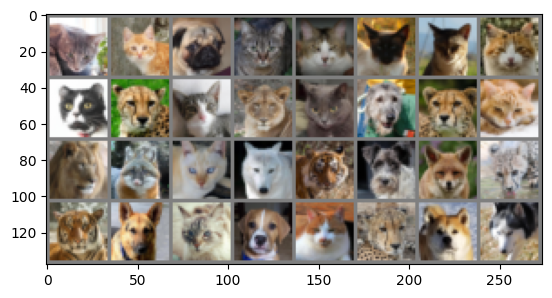

In [6]:
x = next(iter(train_dataloader))

from matplotlib import pyplot as plt
grid_img = make_grid(x[0]).permute(1, 2, 0)
grid_img = (grid_img - grid_img.min()) / (grid_img.max() - grid_img.min())
plt.imshow(grid_img)

## Create model components for diffusion

For image generation, a typical model architecture can be a UNet or a transformer. We use UNet in this notebook.

Below are some utility functions and classesfor the model architecture.



### Library code for model architecture

In [7]:
"""
From: https://github.com/VSehwag/minimal-diffusion/blob/main/unets.py
"""
from abc import abstractmethod

import math
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def conv_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D convolution module.
    """
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """
    Create a linear module.
    """
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D average pooling module.
    """
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def update_ema(target_params, source_params, rate=0.99):
    """
    Update target parameters to be closer to those of source parameters using
    an exponential moving average.

    :param target_params: the target parameter sequence.
    :param source_params: the source parameter sequence.
    :param rate: the EMA rate (closer to 1 means slower).
    """
    for targ, src in zip(target_params, source_params):
        targ.detach().mul_(rate).add_(src, alpha=1 - rate)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def normalization(channels):
    """
    Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = th.exp(
        -math.log(max_period) * th.arange(start=0, end=half, dtype=th.float32) / half
    ).to(device=timesteps.device)
    if timesteps.ndim == 1:
        args = timesteps[:, None].float() * freqs[None]
    else:
        args = timesteps.float() * freqs[None]
    embedding = th.cat([th.cos(args), th.sin(args)], dim=-1)
    if dim % 2:
        embedding = th.cat([embedding, th.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.

    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(th.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with th.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with th.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = th.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads


class AttentionPool2d(nn.Module):
    """
    Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py
    """

    def __init__(
        self,
        spacial_dim: int,
        embed_dim: int,
        num_heads_channels: int,
        output_dim: int = None,
    ):
        super().__init__()
        self.positional_embedding = nn.Parameter(
            th.randn(embed_dim, spacial_dim ** 2 + 1) / embed_dim ** 0.5
        )
        self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = th.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(HW+1)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(HW+1)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0]


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            out = F.interpolate(
                x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest"
            )
        else:
            out = F.interpolate(x, scale_factor=2, mode="nearest")
        if x.shape[-1] == x.shape[-2] == 3:
            # upsampling layer transform [3x3] to [6x6]. Manually paddding it to make [7x7]
            out = F.pad(out, (1, 0, 1, 0))
        if self.use_conv:
            out = self.conv(out)
        return out


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(
                dims, self.channels, self.out_channels, 3, stride=stride, padding=1
            )
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), True)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param emb_dim: base dimension of timestep embedding.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        time_emb_factor=4,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * time_emb_factor
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=1)),
        )

    def forward(self, t, x, y=None, *args, **kwargs):
        """
        Apply the model to an input batch.
        :param t: a 1-D batch of timesteps.
        :param x: an [N x C x ...] Tensor of inputs.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """

        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"

        hs = []
        emb = self.time_embed(timestep_embedding(t, self.model_channels))
        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)
        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)


def UNetBig(
    image_size,
    in_channels=3,
    out_channels=3,
    base_width=192,
    num_classes=None,
):
    if image_size == 128:
        channel_mult = (1, 1, 2, 3, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    elif image_size == 32:
        channel_mult = (1, 2, 2, 2)
    elif image_size == 28:
        channel_mult = (1, 2, 2, 2)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    if image_size == 28:
        attention_resolutions = "28,14,7"
    else:
        attention_resolutions = "32,16,8"
    for res in attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    return UNetModel(
        image_size=image_size,
        in_channels=in_channels,
        model_channels=base_width,
        out_channels=out_channels,
        num_res_blocks=3,
        attention_resolutions=tuple(attention_ds),
        dropout=0.1,
        channel_mult=channel_mult,
        num_classes=num_classes,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=4,
        num_head_channels=64,
        num_heads_upsample=-1,
        use_scale_shift_norm=True,
        resblock_updown=True,
        use_new_attention_order=True,
    )


def UNet(
    image_size,
    in_channels=3,
    out_channels=3,
    base_width=64,
    num_classes=None,
):
    if image_size == 128:
        channel_mult = (1, 1, 2, 3, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    elif image_size == 32:
        channel_mult = (1, 2, 2, 2)
    elif image_size == 28:
        channel_mult = (1, 2, 2, 2)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    if image_size == 28:
        attention_resolutions = "28,14,7"
    else:
        attention_resolutions = "32,16,8"
    for res in attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    return UNetModel(
        image_size=image_size,
        in_channels=in_channels,
        model_channels=base_width,
        out_channels=out_channels,
        num_res_blocks=3,
        attention_resolutions=tuple(attention_ds),
        dropout=0.1,
        channel_mult=channel_mult,
        num_classes=num_classes,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=4,
        num_head_channels=64,
        num_heads_upsample=-1,
        use_scale_shift_norm=True,
        resblock_updown=True,
        use_new_attention_order=True,
    )


def UNetSmall(
    image_size,
    in_channels=3,
    out_channels=3,
    base_width=32,
    num_classes=None,
):
    if image_size == 128:
        channel_mult = (1, 1, 2, 3, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    elif image_size == 32:
        channel_mult = (1, 2, 2, 2)
    elif image_size == 28:
        channel_mult = (1, 2, 2, 2)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    if image_size == 28:
        attention_resolutions = "28,14,7"
    else:
        attention_resolutions = "32,16,8"
    for res in attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    return UNetModel(
        image_size=image_size,
        in_channels=in_channels,
        model_channels=base_width,
        out_channels=out_channels,
        num_res_blocks=2,
        attention_resolutions=tuple(attention_ds),
        time_emb_factor=2,
        dropout=0.1,
        channel_mult=channel_mult,
        num_classes=num_classes,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=4,
        num_head_channels=32,
        num_heads_upsample=-1,
        use_scale_shift_norm=True,
        resblock_updown=True,
        use_new_attention_order=True,
    )

### Create model (the user logic)

In [8]:
device = torch.device("cuda")
denoising_model = UNet(
    image_size=config.resolution,
).to(device)

print(f"model params: {sum(p.numel() for p in denoising_model.parameters()) / 1e6:.2f} M")

model params: 14.42 M


### Optimizer

In [9]:
optimizer = optim.AdamW(denoising_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

## Train




### Forward diffusion

Forward diffusion can be considered as "data augmentation" in the training step. It adds noise to the data to challenge the model to be able to tell apart signal from noise. Diffusion is a particular way of adding noise, with a carefully designed noise schedule.

The forward diffusion defines a sequence of images:

$$x_0, x_1, x_2, ..., x_T$$

where T is the number of diffusion steps (e.g. 1000).

Similar to an algebraic sequence with a common difference, the diffusion sequence has a common noise $\mathbf\epsilon$. The recursive formula is:

$$
x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{\beta_t} \mathbf\epsilon
$$

where $\beta_t = 1 - \alpha_t$ is the variance of the noise at time $t$. This relationship is primarily a design choice that simplifies the mathematics and makes the derivations more elegant and manageable.

One can then derive the explicit formula for $x_t$ expressed in terms of $x_0$ and $\mathbf\epsilon$:

$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \mathbf\epsilon
$$

where $\bar\alpha_t = \prod_{i=1}^t \alpha_i$ is the cumulative product of the variance of the noise at time $t$.

The forward diffusion process is thus defined by this noise schedule: $\beta_1, \beta_2, ..., \beta_T$.



In [10]:
def forward_diffusion(x_0, t, noise_schedule, noise=None):
    _ts = t.view(-1, 1, 1, 1)
    if noise is None:
        noise = torch.randn_like(x_0)
    assert _ts.max() < len(noise_schedule["alphas_cumprod"]), f"t={_ts.max()} is larger than the length of noise_schedule: {len(noise_schedule['alphas_cumprod'])}"
    alpha_prod_t = noise_schedule["alphas_cumprod"][_ts]
    x_t = (alpha_prod_t ** 0.5) * x_0 + ((1 - alpha_prod_t) ** 0.5) * noise
    return x_t, noise


#### Noise schedule

The range of $\beta_t$ is empirically chosen to be between 1e-4 and 0.02. We can plot the noise schedule curves to visualize the blending ratio between the clean data and the noise, and how it changes over "time" through the diffusion process.

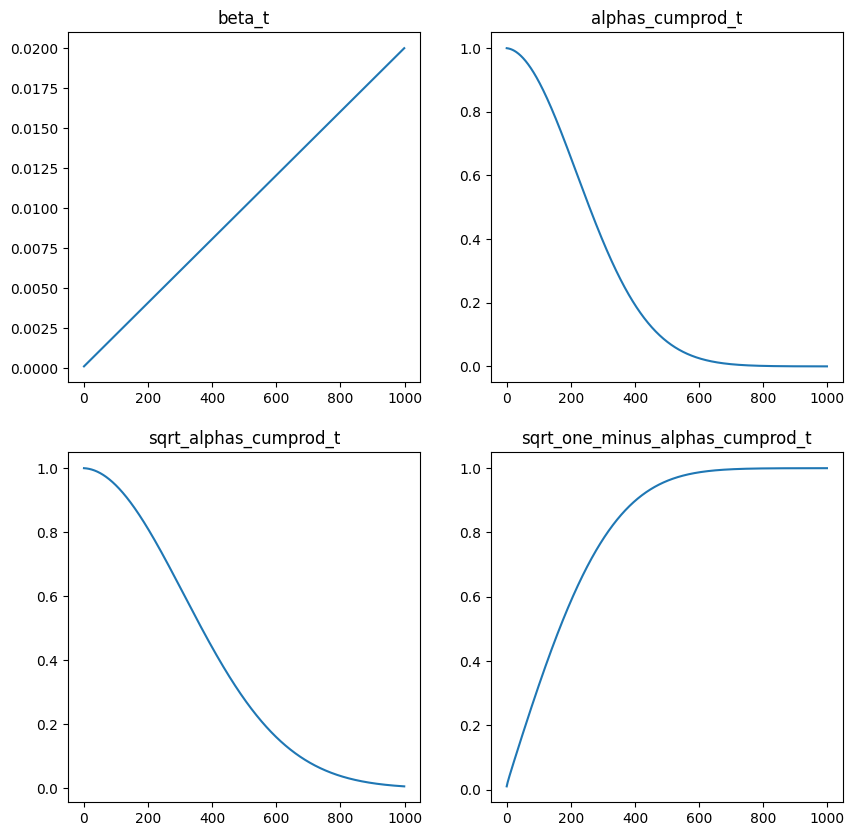

In [11]:
beta_min, beta_max = 1e-4, 0.02
# beta_min, beta_max = 1e-4, 1
# beta_min, beta_max = 0, 0.02

def create_noise_schedule(n_T: int, device: torch.device) -> Dict[str, torch.Tensor]:
    betas = torch.linspace(beta_min, beta_max, n_T).to(device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0).to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1).to(device), alphas_cumprod[:-1].to(device)])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance,
    }


noise_schedule = create_noise_schedule(config.num_denoising_steps, device)

# plot the schedule
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.plot(range(1000), noise_schedule["betas"].cpu().numpy())
plt.title("beta_t")

plt.subplot(2, 2, 2); plt.plot(range(1000), noise_schedule["alphas_cumprod"].cpu().numpy())
_ = plt.title("alphas_cumprod_t")

plt.subplot(2, 2, 3); plt.plot(range(1000), noise_schedule["sqrt_alphas_cumprod"].cpu().numpy())
plt.title("sqrt_alphas_cumprod_t")

plt.subplot(2, 2, 4); plt.plot(range(1000), noise_schedule["sqrt_one_minus_alphas_cumprod"].cpu().numpy())
_ = plt.title("sqrt_one_minus_alphas_cumprod_t")

### Visualizing forward diffusion on an image

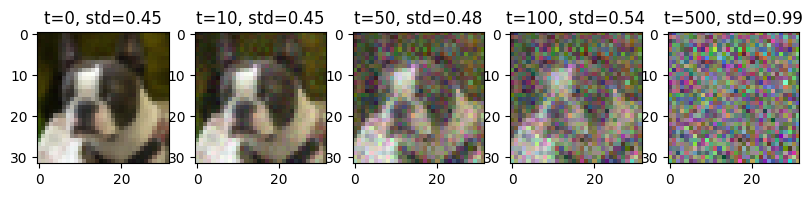

In [12]:
# Let's see what forward diffusion does.
x_0, _ = next(iter(val_dataloader))
x_0 = x_0.to(device)
x_t_list = []
common_noise = torch.randn_like(x_0)
# print(f"x_0 std:", x_0[0].std().item())

noise_levels = [0, 10, 50, 100, 500]
for t in noise_levels:
  t = torch.full((x_0.shape[0],), t, device=device)
  x_t_list.append(forward_diffusion(x_0, t, noise_schedule, noise=common_noise)[0])

# visualize
plt.figure(figsize=(20, 5))
for i, (t, x_t) in enumerate(zip(noise_levels, x_t_list)):
  # print(x_t[0].min().item(), x_t[0].max().item())
  plt.subplot(1, 10, i+1)
  plt.title(f"t={t}, std={x_t[0].std():.2f}")
  img = x_t[0].cpu().numpy().transpose(1, 2, 0)
  img = (img - img.min()) / (img.max() - img.min())
  plt.imshow(img)
  if i >= 10:
    break


Through forward diffusion, the image quality actually appears to degrade quickly. By the time $t=100$, the cat is almost not recognizable. By $t=500$, the image is almost completely noise to the eye. Much of the diffusion process is spent on the "noise-dominant" regime, where the structured image is lost and what remains is a Gaussian-like noisy pattern.

This is helpful for the model to learn to denoise the image.

- By including a long regime where the image is essentially noise, the model learns how to reconstruct a clean image from a broad range of noise levels. This comprehensive exposure helps the model become more robust and generalize better.

- The final goal at sampling time is to start from pure noise (around $x_T$) and iteratively denoise until reaching a plausible sample $x_0$. If the model had fewer steps and tried to denoise a still somewhat structured image in fewer transitions, it might be harder to learn a smooth, stable backward trajectory. The long noise regime ensures the model is comfortable dealing with extremely noisy inputs and making small, incremental corrections.
​

## Training loop

The core training step can be implemented in under 10 lines of code.

We teach the model to predict the "common noise" $\mathbf\epsilon$ that produced the diffusion sequence, based on $x_t$ at any time $t$. No matter where it is, the model needs to help the image get back to $x_0$.

In [13]:
%%time
from tqdm.auto import tqdm
import itertools

criterion = MSELoss()
denoising_model.train()

def train(denoising_model, steps=100):
  print("Training on device:", device)
  max_train_steps = steps

  train_progress_bar = tqdm(enumerate(itertools.cycle(train_dataloader)))

  num_examples = 0
  for step, (x_0, _) in train_progress_bar:
    x_0 = x_0.to(device)  # x_0 is the clean data to teach the model to generate
    optimizer.zero_grad()

    #######################################
    # Start of Core training step
    #######################################
    noise = torch.randn(x_0.shape).to(device)
    t = torch.randint(0, config.num_denoising_steps, (x_0.shape[0],), device=device).long()
    x_t, true_noise = forward_diffusion(x_0, t, noise_schedule, noise=noise)

    predicted_noise = denoising_model(t=t, x=x_t)

    loss = criterion(predicted_noise, true_noise)
    loss.backward();
    # torch.nn.utils.clip_grad_norm_(denoising_model.parameters(), 1)  # try commenting it out
    optimizer.step()
    #######################################
    # End of Core training step
    #######################################

    train_progress_bar.set_postfix({"loss": loss.cpu().item()})
    num_examples += len(x_0)

    if step >= max_train_steps:
      print(f"Reached the max training steps:", max_train_steps)
      break

  print(f"Trained on {num_examples} examples.")
  return loss


loss = train(denoising_model, steps=100)

Training on device: cuda


0it [00:00, ?it/s]

Reached the max training steps: 100
Trained on 3232 examples.
CPU times: user 13 s, sys: 1.92 s, total: 15 s
Wall time: 15 s


## Generate

### The sampling algorithm: reversing the diffusion process

The sampling algorithm is the reverse of the forward diffusion process. It starts from $x_T$, a pure noise image, and iteratively denoise until reaching $x_0$.

The formula for one "denoising" step is:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1 - \bar\alpha_t}} \mathbf\epsilon_{\theta}(\mathbf{x_t}, t)) + \sqrt{\tilde\beta_t} \mathbf z_t \tag{1}
$$

where $z_t ~ \mathcal{N}(0, 1)$ is Gaussian noise (independent from $\mathbf\epsilon$) that is sampled at each denoising step, and $\tilde\beta_t = \frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} \beta_t$ is the variance of the noise at time $t$.


#### The clamping

If you compare the `denoising_step` function below with the implementation in the 2D point cloud tutorial, you will find that the one here to be more complex. It implements the following formula:

$$
\hat x_{0} = \frac{1}{\sqrt{\bar\alpha_t}} \left(x_t - \sqrt{1-\bar\alpha_t} \cdot \mathbf\epsilon_{\theta}(\mathbf{x_t}, t)\right) \tag{2}
$$

then

$$
x_{t-1} =  \frac{\beta_t\sqrt{\bar\alpha_{t-1}}}{1-\bar\alpha_t} \cdot \textrm{Clamp}(\hat x_{0}) + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} x_t  + \sqrt{\beta_t} \mathbf z_t \tag{3}
$$

where $\textrm{Clamp}(\hat x_{0})$ is the clamping function that limits the range of the predicted image to be within $[-1, 1]$.

If there is no clamping, equation (1) is mathematically equivalent to equations (2) and (3) combined (derivations [here](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)). However, clamping is found to be helpful in generating high quality images, especially during the early iterations of the training.

In summary, instead of directly predicting the previous sample,

$$
x_{t} \rightarrow x_{t-1}
$$

we predict the clean sample

$$
x_{t} \rightarrow x_{0}
$$

and then apply forward diffusion on the clean sample to get $x_{t-1}$, with an optional clamping:

$$
x_{0} \rightarrow \textrm{Clamp}(x_{0}) \rightarrow x_{t-1}
$$.

To see its effect, the more direct implementation `denoising_step_direct()` is also included for comparison. We will see why the new implementation with clamping is necessary.


In [14]:
def denoising_step(denoising_model, x_t, t, noise_schedule, thresholding=False, clip_sample=True, clip_sample_range=1.0):
    """
    This is the backward diffusion step, with the effect of denoising.
    """
    if isinstance(t, int):
        t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device)
    else:
        t_tensor = t
    with torch.no_grad():
        model_output = denoising_model(t=t_tensor, x=x_t)
    if hasattr(model_output, "sample"):
        model_output = model_output.sample

    # Extract relevant values from noise_schedule
    alpha_prod_t = noise_schedule["alphas_cumprod"][t_tensor]
    # deal with t=0 case where t can be a tensor
    alpha_prod_t_prev = torch.where(t_tensor > 0,
                                    noise_schedule["alphas_cumprod"][t_tensor - 1],
                                    torch.ones_like(t_tensor, device=x_t.device))

    # Reshape alpha_prod_t_prev for proper broadcasting
    alpha_prod_t = alpha_prod_t.view(-1, 1, 1, 1)
    alpha_prod_t_prev = alpha_prod_t_prev.view(-1, 1, 1, 1)

    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t

    # Compute the previous sample mean
    pred_original_sample = (x_t - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

    if clip_sample:
        pred_original_sample = torch.clamp(pred_original_sample, -clip_sample_range, clip_sample_range)

    # Compute the coefficients for pred_original_sample and current sample
    pred_original_sample_coeff = (alpha_prod_t_prev ** 0.5 * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** 0.5 * beta_prod_t_prev / beta_prod_t

    # Compute the previous sample
    pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * x_t

    # Add noise
    variance = torch.zeros_like(x_t)
    variance_noise = torch.randn_like(x_t)

    # Handle t=0 case where t can be a tensor
    non_zero_mask = (t_tensor != 0).float().view(-1, 1, 1, 1)
    variance = non_zero_mask * ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t)
    variance = torch.clamp(variance, min=1e-20)

    pred_prev_sample = pred_prev_sample + (variance ** 0.5) * variance_noise

    return pred_prev_sample


def denoising_step_direct(
    denoising_model,
    x_t,
    t,
    noise_schedule,
    clip_sample=True,
    clip_sample_range=1.0,
):
    """
    This is the backward diffusion step, with the effect of denoising.
    """
    if isinstance(t, int):
        t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device)
    else:
        t_tensor = t

    with torch.no_grad():
        eps_theta = denoising_model(t=t_tensor, x=x_t)
    if hasattr(eps_theta, "sample"):
        eps_theta = eps_theta.sample

    # Extract alphas from noise schedule
    alpha_t = noise_schedule["alphas"][t_tensor]
    alpha_t_cumprod = noise_schedule["alphas_cumprod"][t_tensor]

    # Reshape for broadcasting
    view_shape = (-1,) + (1,) * (x_t.ndim - 1)
    alpha_t = alpha_t.view(*view_shape)
    alpha_t_cumprod = alpha_t_cumprod.view(*view_shape)

    # Calculate epsilon factor
    eps_factor = (1 - alpha_t) / (1 - alpha_t_cumprod).sqrt()

    # Calculate mean for reverse process
    mean = (1 / torch.sqrt(alpha_t)) * (x_t - eps_factor * eps_theta)

    # Add noise scaled by variance for non-zero timesteps
    noise = torch.randn_like(x_t)
    beta_t = 1 - alpha_t
    variance = beta_t * (1 - alpha_t_cumprod / alpha_t) / (1 - alpha_t_cumprod)
    variance = torch.clamp(variance, min=1e-20)  # Add clamp to prevent numerical instability
    
    # Mask out noise for t=0 timesteps
    non_zero_mask = (t_tensor > 0).float().view(*view_shape)
    noise_scale = torch.sqrt(variance) * non_zero_mask
    
    pred_prev_sample = mean + noise_scale * noise

    # Apply clipping
    if clip_sample:
        pred_prev_sample = torch.clamp(pred_prev_sample, -clip_sample_range, clip_sample_range)

    return pred_prev_sample

def generate_samples_by_denoising(denoising_model, x_T, noise_schedule, n_T, device, thresholding=False, clip_sample=True, clip_sample_range=1.0, seed=0, method="direct"):
    """
    This is the generation process.
    """
    torch.manual_seed(seed)

    x_t = x_T.to(device)
    pbar = tqdm(range(n_T - 1, -1, -1))
    for t in pbar:
        if method == "direct":
            x_t = denoising_step_direct(denoising_model, x_t, t, noise_schedule, clip_sample, clip_sample_range)
        else:
            x_t = denoising_step(denoising_model, x_t, t, noise_schedule, thresholding, clip_sample, clip_sample_range)
        pbar.set_postfix({"std": x_t.std().item()})

    # print("raw x_t range", x_t.min(), x_t.max())
    x_t = (x_t / 2 + 0.5).clamp(0, 1)
    # print("after clamp", x_t.min(), x_t.max())
    return x_t

### Visualize sampled images

#### Without clamping

First we visualize the sampled images without clamping.

Loss of the denoising model: 0.04251774773001671


  0%|          | 0/1000 [00:00<?, ?it/s]

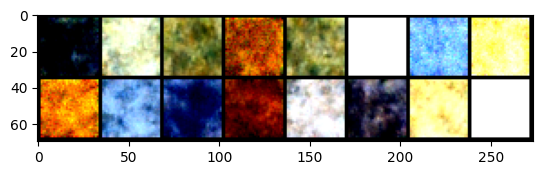

In [15]:
# visualize the sampled images
def visualize_sampled_images(method=None):
  print("Loss of the denoising model:", loss.item())
  x_T = torch.randn(16, 3, 32, 32)
  x_sampled = generate_samples_by_denoising(
    denoising_model, x_T,
    noise_schedule, n_T=1000,
    device=device,
    clip_sample=False if method == "direct" else True,
    clip_sample_range=1.0,
    method=method,
  )
  x_sampled = x_sampled * 255

  sampled = make_grid(x_sampled).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
  _ = plt.imshow(sampled)


visualize_sampled_images(method="direct")

#### With clamping

Now we visualize the sampled images with clamping.

Loss of the denoising model: 0.04251774773001671


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 30.7 s, sys: 63 ms, total: 30.7 s
Wall time: 30.6 s


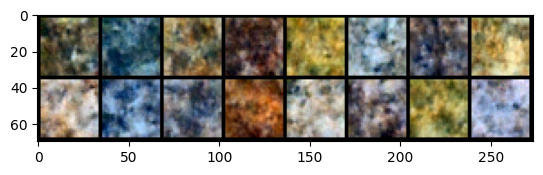

In [16]:
%%time
visualize_sampled_images()

### Train some more

In [17]:
%%time
# Train some more

loss = train(denoising_model, steps=1000)
print("loss:", loss.item())

Training on device: cuda


0it [00:00, ?it/s]

Reached the max training steps: 1000
Trained on 31998 examples.
loss: 0.028803734108805656
CPU times: user 2min 9s, sys: 17.6 s, total: 2min 27s
Wall time: 2min 37s


Again, let's compare the sampled images with and without clamping.

#### Generate with clamping

Loss of the denoising model: 0.028803734108805656


  0%|          | 0/1000 [00:00<?, ?it/s]

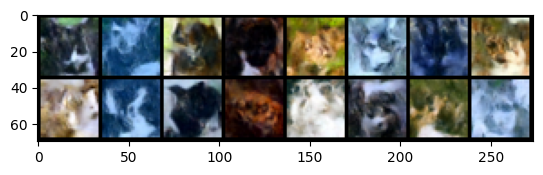

In [18]:
visualize_sampled_images()

#### Generate without clamping

Loss of the denoising model: 0.028803734108805656


  0%|          | 0/1000 [00:00<?, ?it/s]

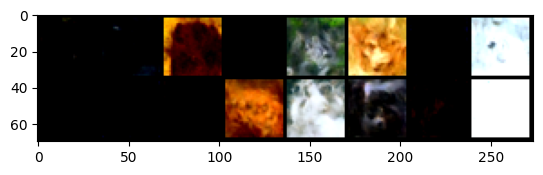

In [19]:
visualize_sampled_images(method="direct")

### Train even more

#### Generate with clamping

Training on device: cuda


0it [00:00, ?it/s]

Reached the max training steps: 5000
Trained on 159828 examples.
loss: 0.05068334937095642
Loss of the denoising model: 0.05068334937095642


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 11min 21s, sys: 1min 27s, total: 12min 49s
Wall time: 12min 49s


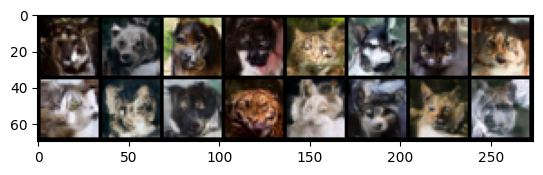

In [20]:
%%time
for g in optimizer.param_groups:
    g['lr'] = 1e-4  # reduce learning rate
loss = train(denoising_model, steps=5000)
print("loss:", loss.item())
visualize_sampled_images()

#### Generate with clamping

Loss of the denoising model: 0.05068334937095642


  0%|          | 0/1000 [00:00<?, ?it/s]

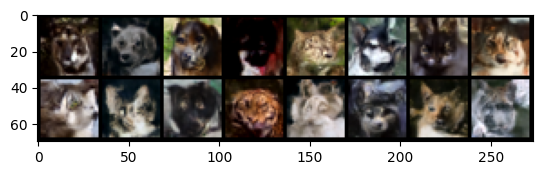

In [21]:
visualize_sampled_images(method="direct")

### And, some more

In [22]:
%%time
for g in optimizer.param_groups:
    g['lr'] = 1e-4  # reduce learning rate
loss = train(denoising_model, steps=12000)
print("loss:", loss.item())

Training on device: cuda


0it [00:00, ?it/s]

Reached the max training steps: 12000
Trained on 383539 examples.
loss: 0.02879544161260128
CPU times: user 26min 7s, sys: 3min 29s, total: 29min 36s
Wall time: 29min 37s


Loss of the denoising model: 0.02879544161260128


  0%|          | 0/1000 [00:00<?, ?it/s]

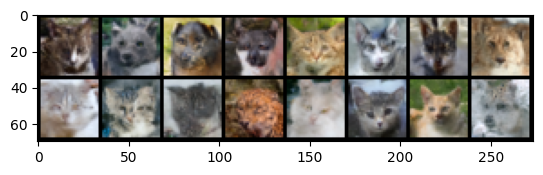

In [23]:
visualize_sampled_images(method="direct")

Loss of the denoising model: 0.02879544161260128


  0%|          | 0/1000 [00:00<?, ?it/s]

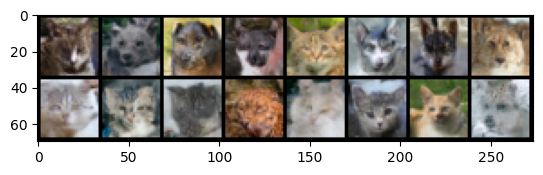

In [24]:
visualize_sampled_images()

We can see that the images generating without clamping now caught up in quality, as the model becomes more robust.